# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  


In [1]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
from utils.losses import FwdLoss, EMLoss, FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, scoring_matrix
from utils.losses1 import UpperBoundWeakProperLoss
from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling


# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [2]:
dataset_name = 'mnist'
Data = Data_handling(
    # dataset='mnist',
    dataset=dataset_name,
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42
)

In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y
print(Data.test_dataset.targets)
df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in Data.train_dataset.targets.numpy()]
df


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_775,feature_776,feature_777,feature_778,feature_779,feature_780,feature_781,feature_782,feature_783,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [4]:
Data.num_classes

10

In [5]:
""" df_2_plot = df.iloc[0:1000]
features = ['feature_102', 'feature_103']
visualize_dataset(
    df_2_plot,
    features=features,
    classes=Data.num_classes,
    title=dataset_name,
) """


" df_2_plot = df.iloc[0:1000]\nfeatures = ['feature_102', 'feature_103']\nvisualize_dataset(\n    df_2_plot,\n    features=features,\n    classes=Data.num_classes,\n    title=dataset_name,\n) "

In [6]:
""" df_2_plot[[features[0], features[1]]] """


' df_2_plot[[features[0], features[1]]] '

Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [7]:
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=0.2)
# weakener.generate_M(model_class='unif_noise', corr_p=0.5) #Try this for noisy labels
print(f"Generated M matrix:\n{weakener.M}")
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)

z = weakener.generate_weak(true_onehot)
print(f"Generated z (noisy labels):\n{z}")
#print(f"Generated w (multi-label matrix):\n{w}")

Data.include_weak(z)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')

batch = next(iter(train_loader))
xb, wb, yb = batch
print(f"Inputs batch shape: {xb.shape}")
print(f"Weak (partial) labels shape: {wb.shape}")
print(f"True one-hot labels shape: {yb.shape}")

Generated M matrix:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.34217728e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.34217728e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.35544320e-02 3.35544320e-02]
 ...
 [2.04800000e-06 2.04800000e-06 2.04800000e-06 ... 2.04800000e-06
  0.00000000e+00 2.04800000e-06]
 [2.04800000e-06 2.04800000e-06 2.04800000e-06 ... 2.04800000e-06
  2.04800000e-06 0.00000000e+00]
 [5.12000000e-07 5.12000000e-07 5.12000000e-07 ... 5.12000000e-07
  5.12000000e-07 5.12000000e-07]]
Generated z (noisy labels):
tensor([144, 648, 176,  ...,  17,  23,  18], dtype=torch.int32)
Inputs batch shape: torch.Size([64, 784])
Weak (partial) labels shape: torch.Size([64])
True one-hot labels shape: torch.Size([64, 10])


In [8]:
weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in weakener.w.numpy()]
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_775,feature_776,feature_777,feature_778,feature_779,feature_780,feature_781,feature_782,feature_783,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."


In [9]:
# visualize_dataset(
#     df,
#     features=['feature_0', 'feature_1'],
#     classes=3,
#     title='Iris Samples with Pie Markers for Multi-Label Entries'
# )



1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/70: Train Loss: 0.0735, Train Acc: 0.9172, Test Acc: 0.9215, Train Detached Loss: 0.0046, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 0.87 seconds
Epoch 20/70: Train Loss: 0.0732, Train Acc: 0.9246, Test Acc: 0.9240, Train Detached Loss: 0.0043, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.80 seconds
Epoch 30/70: Train Loss: 0.0731, Train Acc: 0.9282, Test Acc: 0.9253, Train Detached Loss: 0.0042, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.94 seconds
Epoch 40/70: Train Loss: 0.0730, Train Acc: 0.9299, Test Acc: 0.9279, Train Detached Loss: 0.0041, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.81 seconds
Epoch 50/70: Train Loss: 0.0730, Train Acc: 0.9311, Test Acc: 0.9280, Train Detached Loss: 0.0041, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.81 seconds
Epoch 60/70: Train Loss: 0.0729, Train Acc: 0.9318, Test Acc:

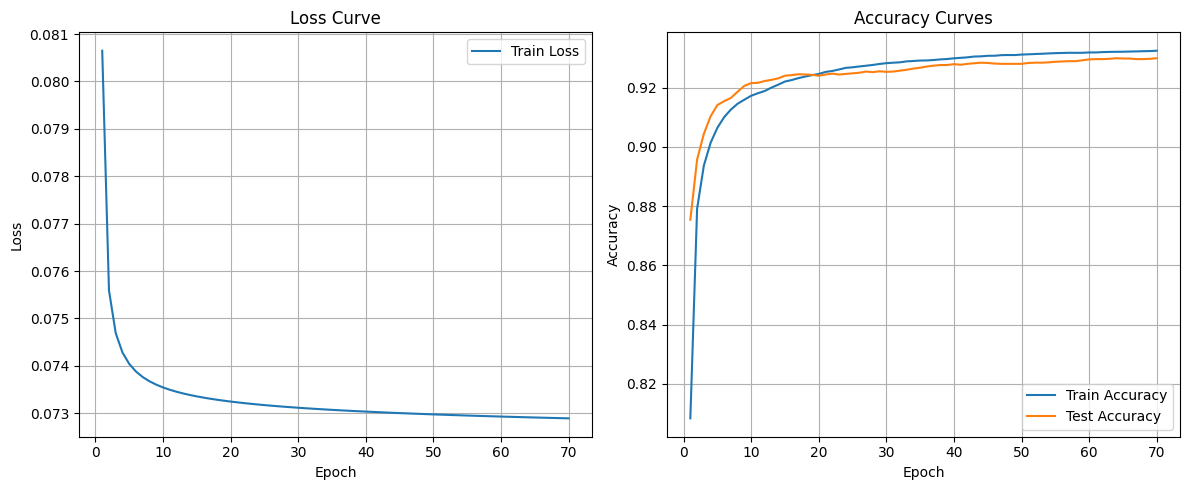

In [10]:
# --- Training helper (to reduce repeated code across experiments) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_training(loss_cls, loss_code, lr=1e-6, num_epochs=60):
    print(f"Using device: {device}")

    model = MLP(
        input_size=Data.num_features,
        hidden_sizes=[],
        output_size=Data.num_classes,
        dropout_p=0,
        bn=False,
        activation='relu'
    )

    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
    )

    em_loss = loss_cls(weakener.M, loss_code=loss_code)

    model, results_df = train_and_evaluate(
        model,        # our MLP on device
        train_loader, # yields (x, w, y)
        test_loader,  # yields (x, y)
        optimizer,    # Adam optimizer
        em_loss,      # loss
        num_epochs,   # total epochs
        corr_p        # used for logging consistency
    )

    print(results_df)

    # Set up a wide figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Loss curves
    ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curves
    ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
    ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return model, results_df


# --- Experiment: MarginalChainProperLoss + cross_entropy ---
model, results_df = run_training(MarginalChainProperLoss, "cross_entropy", lr=1e-6, num_epochs=70)


In [11]:
import os
print(os.getenv("PYTHONBREAKPOINT"))

None


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/70: Train Loss: 0.0735, Train Acc: 0.9172, Test Acc: 0.9215, Train Detached Loss: 0.0046, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 0.86 seconds
Epoch 20/70: Train Loss: 0.0732, Train Acc: 0.9246, Test Acc: 0.9241, Train Detached Loss: 0.0043, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.86 seconds
Epoch 30/70: Train Loss: 0.0731, Train Acc: 0.9282, Test Acc: 0.9253, Train Detached Loss: 0.0042, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.86 seconds
Epoch 40/70: Train Loss: 0.0730, Train Acc: 0.9299, Test Acc: 0.9279, Train Detached Loss: 0.0041, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.86 seconds
Epoch 50/70: Train Loss: 0.0730, Train Acc: 0.9311, Test Acc: 0.9280, Train Detached Loss: 0.0041, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.86 seconds
Epoch 60/70: Train Loss: 0.0729, Train Acc: 0.9318, Test Acc:

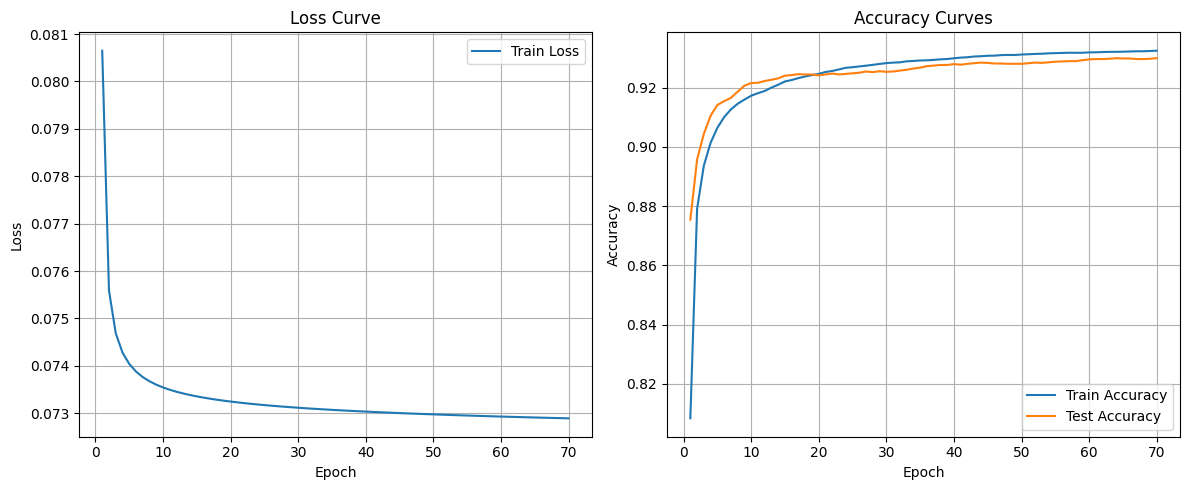

In [12]:
# --- Experiment: ForwardProperLoss + cross_entropy ---
model, results_df = run_training(ForwardProperLoss, "cross_entropy", lr=1e-6, num_epochs=70)


In [ ]:
import torch
from torch import nn

# 1. 固定随机种子
torch.manual_seed(0)

B, C = 5, 4

logits = torch.randn(B, C, requires_grad=True)
z = torch.randint(0, C, (B,))

M = torch.rand(C, C)
M = M / M.sum(dim=1, keepdim=True)
F = M.clone()

# 这里贴上你的 MarginalChainProperLoss 和 ForwardProperLoss 定义
# loss_code="cross_entropy"
# 这里是当时测marginalchain和fwd输出应该完全一样以检测式子到底写没写对的那段

mc_loss_fn = MarginalChainProperLoss(M, loss_code="cross_entropy", reduction="mean")
fw_loss_fn = ForwardProperLoss(F, loss_code="cross_entropy", reduction="mean")

# Marginal chain
logits_mc = logits.clone().detach().requires_grad_(True)
loss_mc = mc_loss_fn(logits_mc, z)
loss_mc.backward()
grad_mc = logits_mc.grad.clone().detach()

# Forward
logits_fw = logits.clone().detach().requires_grad_(True)
loss_fw = fw_loss_fn(logits_fw, z)
loss_fw.backward()
grad_fw = logits_fw.grad.clone().detach()

print("loss_mc:", loss_mc.item())
print("loss_fw:", loss_fw.item())
print("loss diff:", abs(loss_mc.item() - loss_fw.item()))

print("grad same?", torch.allclose(grad_mc, grad_fw, atol=1e-6))
print("grad max diff:", (grad_mc - grad_fw).abs().max().item())


loss_mc: 1.3477718830108643
loss_fw: 1.3477718830108643
loss diff: 0.0
grad same? True
grad max diff: 1.4901161193847656e-08


In [ ]:
# 取一个 batch
# 这也是当时测输出差异的，测fwd和upperbound

xb, zb, yb = next(iter(train_loader))   # 确保 zb 就是 z（weak index）
xb = xb.to(device)
zb = zb.to(device)

logits = model(xb)

fwd_loss_fn = ForwardProperLoss(weakener.M, "cross_entropy").to(device)
ub_loss_fn  = UpperBoundWeakProperLoss(weakener.M, "cross_entropy").to(device)

loss_fwd = fwd_loss_fn(logits, zb)
loss_ub  = ub_loss_fn(logits, zb)

print("loss_fwd:", loss_fwd.item())
print("loss_ub :", loss_ub.item())

g1 = torch.autograd.grad(loss_fwd, logits, retain_graph=True)[0]
g2 = torch.autograd.grad(loss_ub,  logits)[0]
print("grad norm fwd:", g1.norm().item())
print("grad norm ub :",  g2.norm().item())


loss_fwd: 4.5460968017578125
loss_ub : 0.13959792256355286
grad norm fwd: 0.024380946531891823
grad norm ub : 0.024380946531891823


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/70: Train Loss: 0.0047, Train Acc: 0.9172, Test Acc: 0.9215, Train Detached Loss: 0.0046, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 0.80 seconds
Epoch 20/70: Train Loss: 0.0041, Train Acc: 0.9246, Test Acc: 0.9241, Train Detached Loss: 0.0043, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.79 seconds
Epoch 30/70: Train Loss: 0.0039, Train Acc: 0.9282, Test Acc: 0.9253, Train Detached Loss: 0.0042, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.80 seconds
Epoch 40/70: Train Loss: 0.0038, Train Acc: 0.9299, Test Acc: 0.9279, Train Detached Loss: 0.0041, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.79 seconds
Epoch 50/70: Train Loss: 0.0037, Train Acc: 0.9311, Test Acc: 0.9280, Train Detached Loss: 0.0041, Test Detached Loss: 0.0043, Learning Rate: 0.000001, Epoch Time: 0.80 seconds
Epoch 60/70: Train Loss: 0.0036, Train Acc: 0.9318, Test Acc:

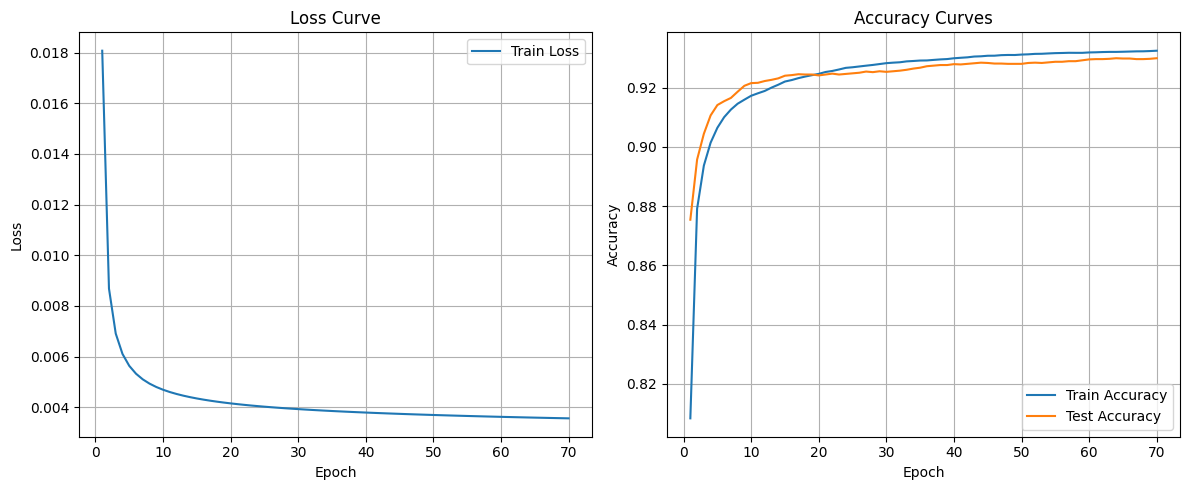

In [15]:
# --- Experiment: UpperBoundWeakProperLoss + cross_entropy ---
model, results_df = run_training(UpperBoundWeakProperLoss, "cross_entropy", lr=1e-6, num_epochs=70)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/80: Train Loss: 0.0021, Train Acc: 0.9207, Test Acc: 0.9239, Train Detached Loss: 0.0049, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 0.93 seconds
Epoch 20/80: Train Loss: 0.0018, Train Acc: 0.9289, Test Acc: 0.9294, Train Detached Loss: 0.0047, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 1.14 seconds
Epoch 30/80: Train Loss: 0.0017, Train Acc: 0.9332, Test Acc: 0.9306, Train Detached Loss: 0.0046, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 0.98 seconds
Epoch 40/80: Train Loss: 0.0016, Train Acc: 0.9356, Test Acc: 0.9309, Train Detached Loss: 0.0046, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 0.88 seconds
Epoch 50/80: Train Loss: 0.0016, Train Acc: 0.9370, Test Acc: 0.9310, Train Detached Loss: 0.0046, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 0.96 seconds
Epoch 60/80: Train Loss: 0.0015, Train Acc: 0.9380, Test Acc:

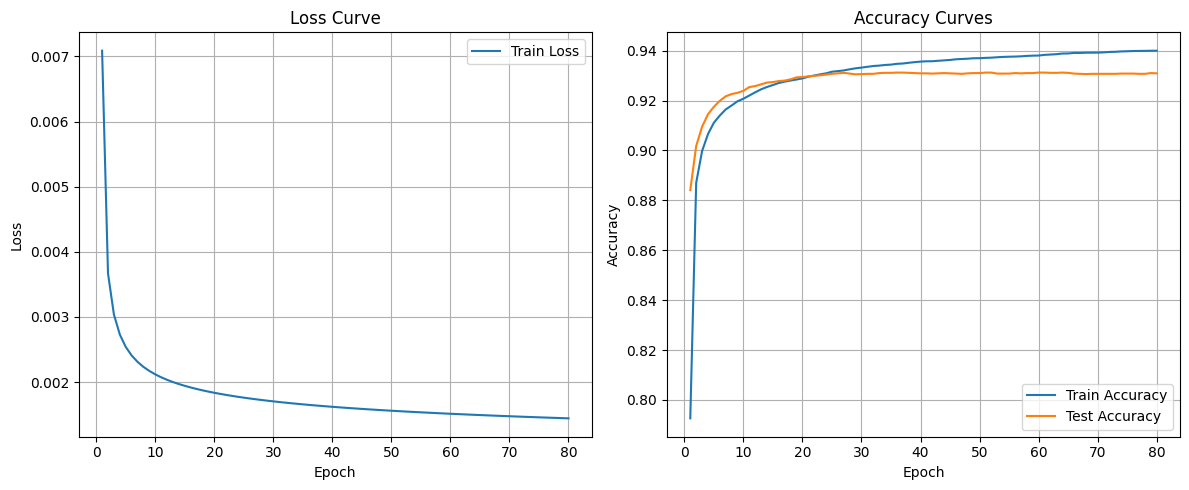

In [26]:
# --- Experiment: MarginalChainProperLoss + ps_2 ---
model, results_df = run_training(MarginalChainProperLoss, "brier", lr=1e-6, num_epochs=80)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/80: Train Loss: 0.0152, Train Acc: 0.9129, Test Acc: 0.9163, Train Detached Loss: 0.0054, Test Detached Loss: 0.0052, Learning Rate: 0.000001, Epoch Time: 1.37 seconds
Epoch 20/80: Train Loss: 0.0152, Train Acc: 0.9197, Test Acc: 0.9208, Train Detached Loss: 0.0050, Test Detached Loss: 0.0049, Learning Rate: 0.000001, Epoch Time: 1.41 seconds
Epoch 30/80: Train Loss: 0.0152, Train Acc: 0.9226, Test Acc: 0.9224, Train Detached Loss: 0.0048, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 1.39 seconds
Epoch 40/80: Train Loss: 0.0152, Train Acc: 0.9242, Test Acc: 0.9230, Train Detached Loss: 0.0048, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 1.47 seconds
Epoch 50/80: Train Loss: 0.0152, Train Acc: 0.9254, Test Acc: 0.9229, Train Detached Loss: 0.0048, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 1.49 seconds
Epoch 60/80: Train Loss: 0.0152, Train Acc: 0.9268, Test Acc:

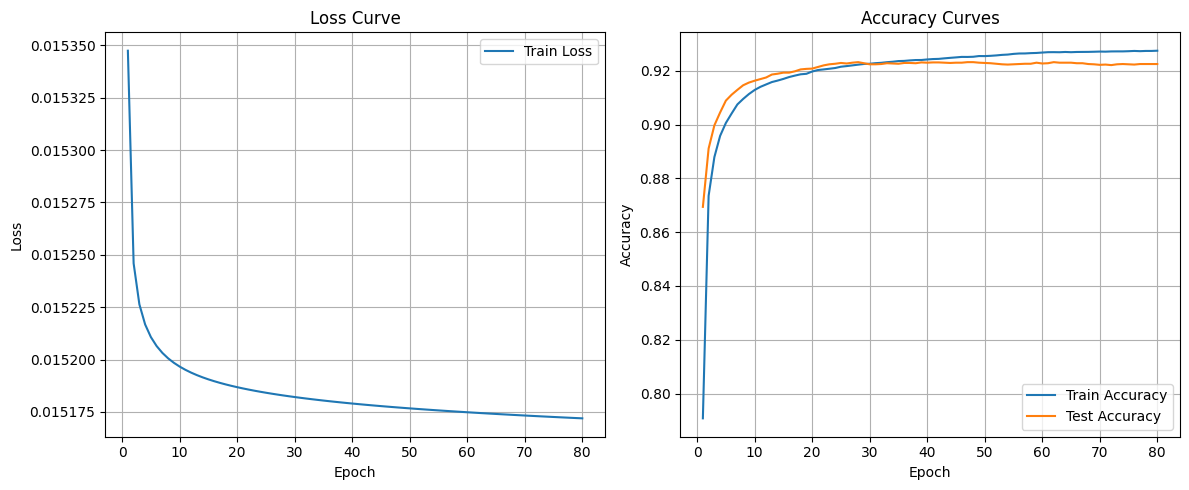

In [27]:
# --- Experiment: MarginalChainProperLoss + ps_2 ---
model, results_df = run_training(ForwardProperLoss, "brier", lr=1e-6, num_epochs=80)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/80: Train Loss: 0.0013, Train Acc: 0.9207, Test Acc: 0.9239, Train Detached Loss: 0.0049, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 0.79 seconds
Epoch 20/80: Train Loss: 0.0012, Train Acc: 0.9289, Test Acc: 0.9294, Train Detached Loss: 0.0047, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 0.79 seconds
Epoch 30/80: Train Loss: 0.0011, Train Acc: 0.9332, Test Acc: 0.9306, Train Detached Loss: 0.0046, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 0.83 seconds
Epoch 40/80: Train Loss: 0.0011, Train Acc: 0.9356, Test Acc: 0.9309, Train Detached Loss: 0.0046, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 0.92 seconds
Epoch 50/80: Train Loss: 0.0011, Train Acc: 0.9370, Test Acc: 0.9310, Train Detached Loss: 0.0046, Test Detached Loss: 0.0046, Learning Rate: 0.000001, Epoch Time: 0.91 seconds
Epoch 60/80: Train Loss: 0.0011, Train Acc: 0.9380, Test Acc:

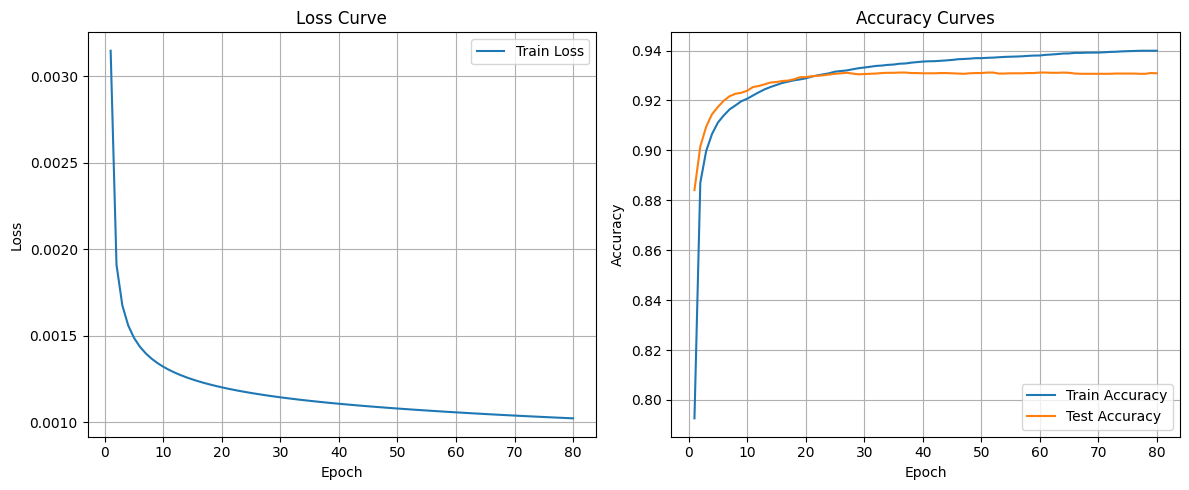

In [28]:
# --- Experiment: MarginalChainProperLoss + ps_2 ---
model, results_df = run_training(UpperBoundWeakProperLoss, "brier", lr=1e-6, num_epochs=80)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/80: Train Loss: -0.0046, Train Acc: 0.4967, Test Acc: 0.4964, Train Detached Loss: 0.1462, Test Detached Loss: 0.1503, Learning Rate: 0.000001, Epoch Time: 0.85 seconds
Epoch 20/80: Train Loss: -0.0046, Train Acc: 0.4988, Test Acc: 0.4973, Train Detached Loss: 0.2194, Test Detached Loss: 0.2254, Learning Rate: 0.000001, Epoch Time: 0.86 seconds
Epoch 30/80: Train Loss: -0.0046, Train Acc: 0.4993, Test Acc: 0.4975, Train Detached Loss: 0.2949, Test Detached Loss: 0.3031, Learning Rate: 0.000001, Epoch Time: 0.85 seconds
Epoch 40/80: Train Loss: -0.0047, Train Acc: 0.4998, Test Acc: 0.4980, Train Detached Loss: 0.3518, Test Detached Loss: 0.3617, Learning Rate: 0.000001, Epoch Time: 0.85 seconds
Epoch 50/80: Train Loss: -0.0047, Train Acc: 0.5000, Test Acc: 0.4980, Train Detached Loss: 0.3783, Test Detached Loss: 0.3889, Learning Rate: 0.000001, Epoch Time: 0.85 seconds
Epoch 60/80: Train Loss: -0.0047, Train Acc: 0.5003, Tes

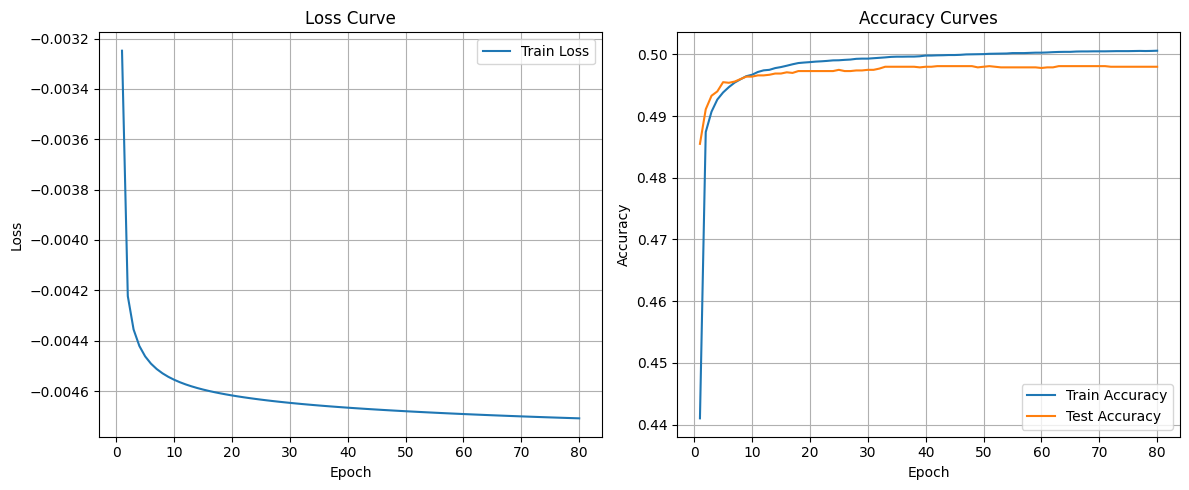

In [19]:
# --- Experiment: MarginalChainProperLoss + ps_2 ---
model, results_df = run_training(MarginalChainProperLoss, "ps_2", lr=1e-6, num_epochs=80)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/80: Train Loss: -0.0001, Train Acc: 0.6784, Test Acc: 0.6812, Train Detached Loss: 0.0673, Test Detached Loss: 0.0692, Learning Rate: 0.000001, Epoch Time: 1.78 seconds
Epoch 20/80: Train Loss: -0.0001, Train Acc: 0.7368, Test Acc: 0.7406, Train Detached Loss: 0.0777, Test Detached Loss: 0.0799, Learning Rate: 0.000001, Epoch Time: 1.43 seconds
Epoch 30/80: Train Loss: -0.0001, Train Acc: 0.7546, Test Acc: 0.7539, Train Detached Loss: 0.1028, Test Detached Loss: 0.1062, Learning Rate: 0.000001, Epoch Time: 1.48 seconds
Epoch 40/80: Train Loss: -0.0001, Train Acc: 0.7574, Test Acc: 0.7568, Train Detached Loss: 0.1138, Test Detached Loss: 0.1176, Learning Rate: 0.000001, Epoch Time: 1.49 seconds
Epoch 50/80: Train Loss: -0.0001, Train Acc: 0.7587, Test Acc: 0.7582, Train Detached Loss: 0.1185, Test Detached Loss: 0.1224, Learning Rate: 0.000001, Epoch Time: 1.42 seconds
Epoch 60/80: Train Loss: -0.0001, Train Acc: 0.7595, Tes

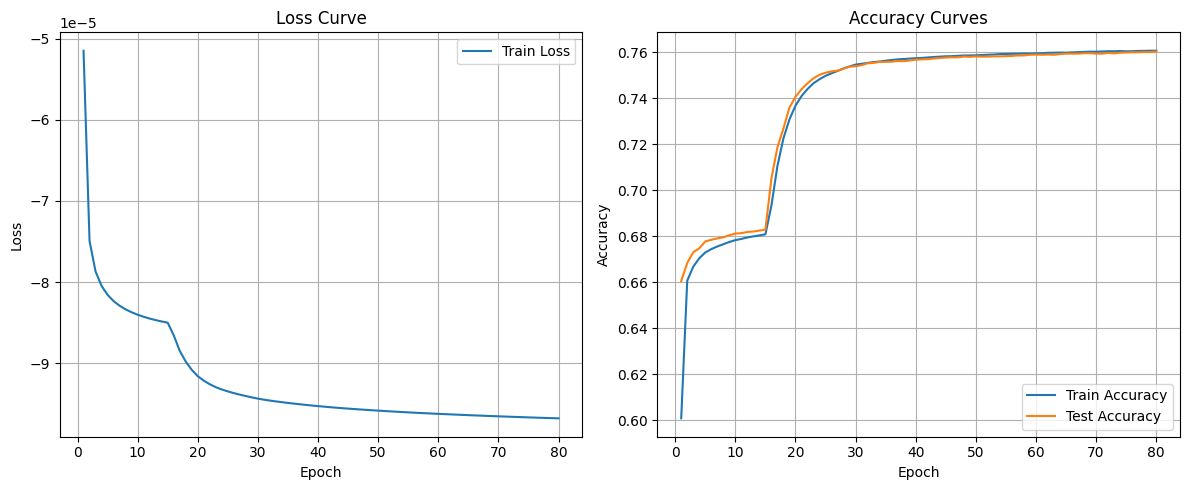

In [ ]:
# --- Experiment: ForwardProperLoss + ps_2 ---
model, results_df = run_training(ForwardProperLoss, "ps_2", lr=1e-6, num_epochs=80)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/100: Train Loss: -0.0046, Train Acc: 0.4967, Test Acc: 0.4964, Train Detached Loss: 0.1462, Test Detached Loss: 0.1503, Learning Rate: 0.000001, Epoch Time: 0.89 seconds
Epoch 20/100: Train Loss: -0.0046, Train Acc: 0.4988, Test Acc: 0.4973, Train Detached Loss: 0.2194, Test Detached Loss: 0.2254, Learning Rate: 0.000001, Epoch Time: 0.87 seconds
Epoch 30/100: Train Loss: -0.0046, Train Acc: 0.4993, Test Acc: 0.4975, Train Detached Loss: 0.2949, Test Detached Loss: 0.3031, Learning Rate: 0.000001, Epoch Time: 0.87 seconds
Epoch 40/100: Train Loss: -0.0047, Train Acc: 0.4998, Test Acc: 0.4980, Train Detached Loss: 0.3518, Test Detached Loss: 0.3617, Learning Rate: 0.000001, Epoch Time: 0.87 seconds
Epoch 50/100: Train Loss: -0.0047, Train Acc: 0.5000, Test Acc: 0.4980, Train Detached Loss: 0.3783, Test Detached Loss: 0.3889, Learning Rate: 0.000001, Epoch Time: 0.87 seconds
Epoch 60/100: Train Loss: -0.0047, Train Acc: 0.500

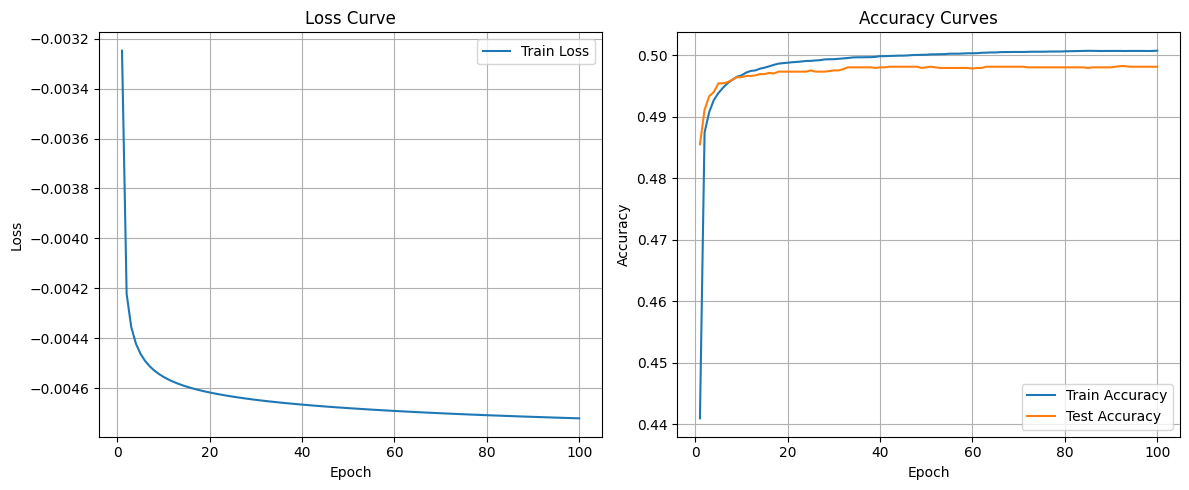

In [33]:
# --- Experiment: UpperBoundWeakProperLoss + ps_2 ---
model, results_df = run_training(UpperBoundWeakProperLoss, "ps_2", lr=1e-6, num_epochs=100)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/90: Train Loss: 0.0389, Train Acc: 0.8715, Test Acc: 0.8793, Train Detached Loss: 0.0061, Test Detached Loss: 0.0060, Learning Rate: 0.000001, Epoch Time: 0.91 seconds
Epoch 20/90: Train Loss: 0.0341, Train Acc: 0.8813, Test Acc: 0.8876, Train Detached Loss: 0.0057, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 0.95 seconds
Epoch 30/90: Train Loss: 0.0315, Train Acc: 0.8867, Test Acc: 0.8911, Train Detached Loss: 0.0055, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 0.89 seconds
Epoch 40/90: Train Loss: 0.0299, Train Acc: 0.8894, Test Acc: 0.8935, Train Detached Loss: 0.0054, Test Detached Loss: 0.0055, Learning Rate: 0.000001, Epoch Time: 0.92 seconds
Epoch 50/90: Train Loss: 0.0286, Train Acc: 0.8905, Test Acc: 0.8952, Train Detached Loss: 0.0053, Test Detached Loss: 0.0055, Learning Rate: 0.000001, Epoch Time: 0.93 seconds
Epoch 60/90: Train Loss: 0.0276, Train Acc: 0.8920, Test Acc:

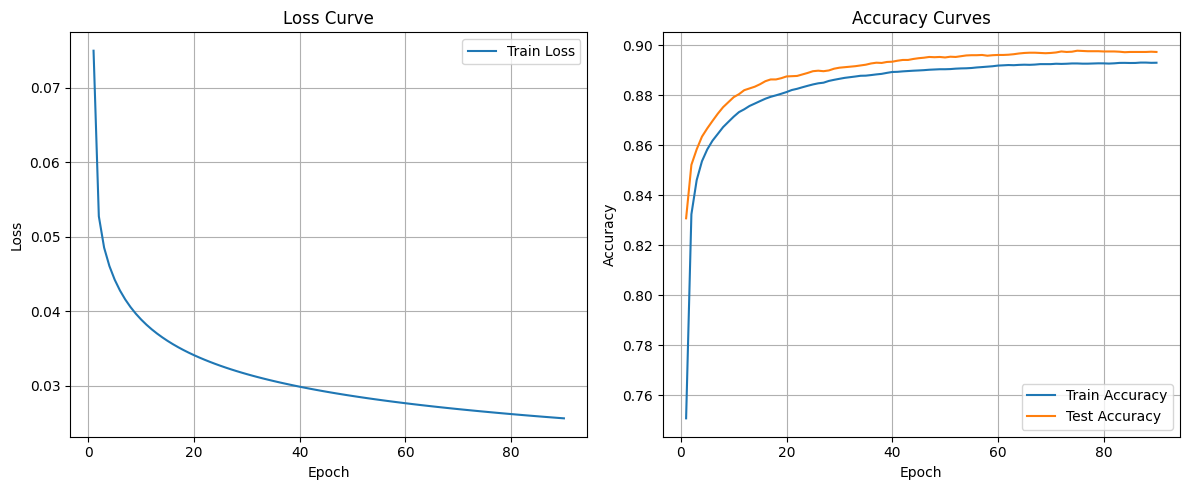

In [34]:
# --- Experiment: MarginalChainProperLoss + tsallis_0.2 ---
model, results_df = run_training(MarginalChainProperLoss, "tsallis_0.2", lr=1e-6, num_epochs=90)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/90: Train Loss: 3.0692, Train Acc: 0.8782, Test Acc: 0.8840, Train Detached Loss: 0.0061, Test Detached Loss: 0.0060, Learning Rate: 0.000001, Epoch Time: 2.60 seconds
Epoch 20/90: Train Loss: 2.9814, Train Acc: 0.8879, Test Acc: 0.8912, Train Detached Loss: 0.0057, Test Detached Loss: 0.0057, Learning Rate: 0.000001, Epoch Time: 2.42 seconds
Epoch 30/90: Train Loss: 2.9335, Train Acc: 0.8924, Test Acc: 0.8947, Train Detached Loss: 0.0055, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 2.40 seconds
Epoch 40/90: Train Loss: 2.9006, Train Acc: 0.8944, Test Acc: 0.8958, Train Detached Loss: 0.0054, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 2.40 seconds
Epoch 50/90: Train Loss: 2.8759, Train Acc: 0.8960, Test Acc: 0.8968, Train Detached Loss: 0.0054, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 2.39 seconds
Epoch 60/90: Train Loss: 2.8564, Train Acc: 0.8975, Test Acc:

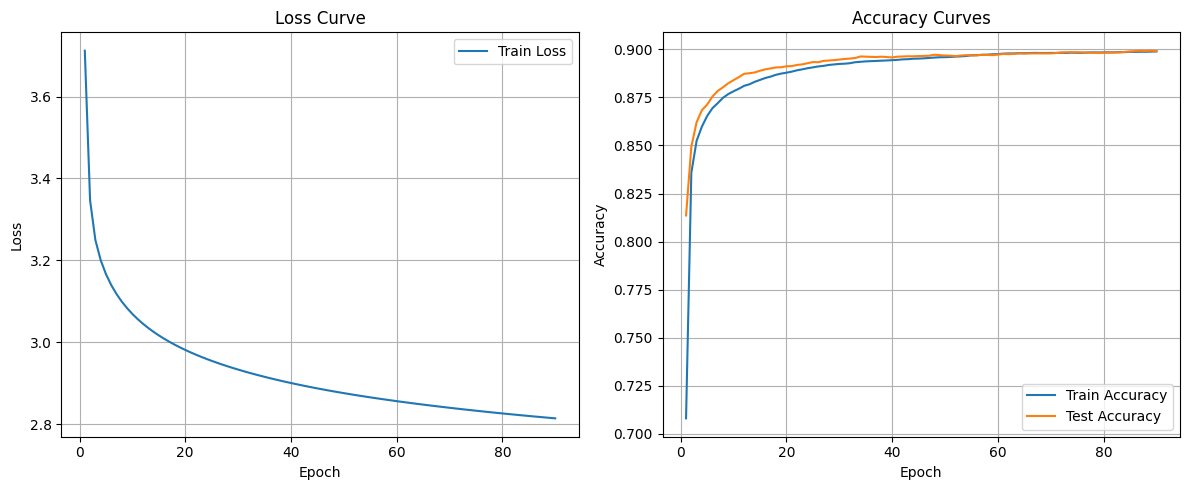

In [35]:
# --- Experiment: ForwardProperLoss + tsallis_0.5 ---
model, results_df = run_training(ForwardProperLoss, "tsallis_0.2", lr=1e-6, num_epochs=90)


Using device: cpu
Initializing MLP model...
784
[]
10
Epoch 10/80: Train Loss: 0.0388, Train Acc: 0.8715, Test Acc: 0.8792, Train Detached Loss: 0.0061, Test Detached Loss: 0.0060, Learning Rate: 0.000001, Epoch Time: 0.90 seconds
Epoch 20/80: Train Loss: 0.0339, Train Acc: 0.8815, Test Acc: 0.8875, Train Detached Loss: 0.0057, Test Detached Loss: 0.0057, Learning Rate: 0.000001, Epoch Time: 0.90 seconds
Epoch 30/80: Train Loss: 0.0312, Train Acc: 0.8867, Test Acc: 0.8907, Train Detached Loss: 0.0055, Test Detached Loss: 0.0056, Learning Rate: 0.000001, Epoch Time: 0.90 seconds
Epoch 40/80: Train Loss: 0.0295, Train Acc: 0.8890, Test Acc: 0.8934, Train Detached Loss: 0.0054, Test Detached Loss: 0.0055, Learning Rate: 0.000001, Epoch Time: 0.90 seconds
Epoch 50/80: Train Loss: 0.0281, Train Acc: 0.8904, Test Acc: 0.8954, Train Detached Loss: 0.0053, Test Detached Loss: 0.0055, Learning Rate: 0.000001, Epoch Time: 0.90 seconds
Epoch 60/80: Train Loss: 0.0271, Train Acc: 0.8917, Test Acc:

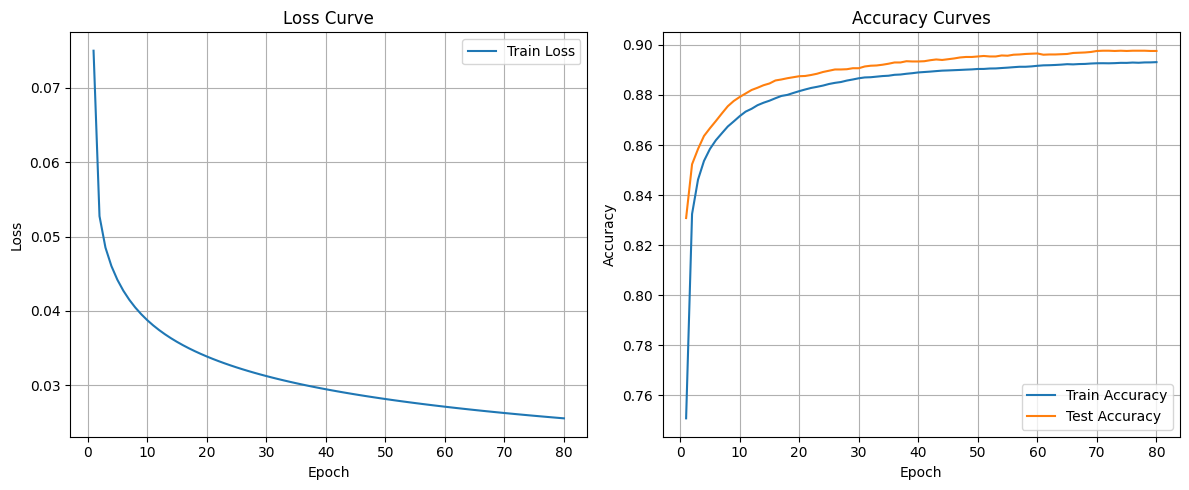

In [ ]:
# --- Experiment: UpperBoundWeakProperLoss + tsallis_0.2 ---
model, results_df = run_training(UpperBoundWeakProperLoss, "tsallis_0.2", lr=1e-6, num_epochs=100)


NameError: name 'clean_results' is not defined

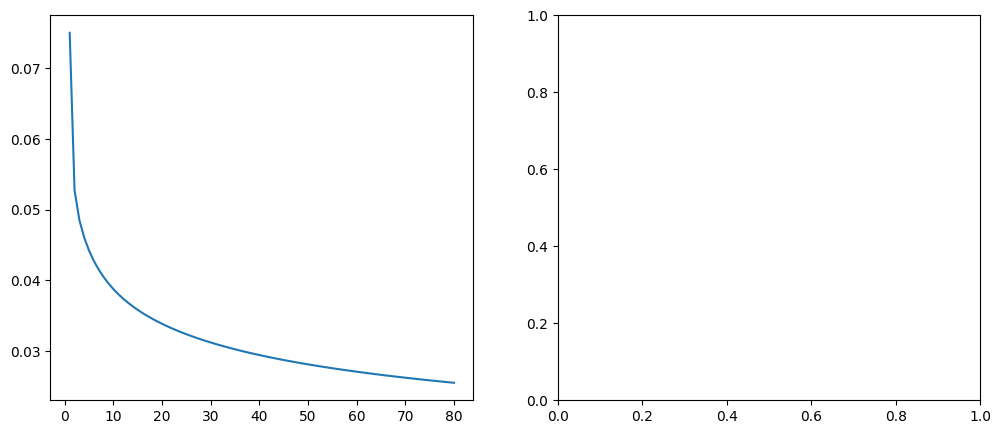

In [25]:
# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Weak Train Loss')
ax1.plot(clean_results['epoch'], clean_results['train_loss'], label='Supervised Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Weak Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Weak Test Accuracy')
ax2.plot(clean_results['epoch'], clean_results['train_acc'],'--', label='Supervised Train Accuracy' )
ax2.plot(clean_results['epoch'], clean_results['test_acc'], '--', label='Supervied Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()